In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [42]:
# Memuat data dari file CSV
file_path = '/content/HistoricalData_1721543882668.csv'  # Sesuaikan dengan path file Anda
data = pd.read_csv(file_path)

In [43]:
# Menghilangkan simbol $ dan mengkonversi kolom harga menjadi tipe numerik
data['Close/Last'] = data['Close/Last'].str.replace('$', '').astype(float)
data['Open'] = data['Open'].str.replace('$', '').astype(float)
data['High'] = data['High'].str.replace('$', '').astype(float)
data['Low'] = data['Low'].str.replace('$', '').astype(float)

In [44]:
# Konversi kolom Date menjadi tipe datetime
data['Date'] = pd.to_datetime(data['Date'])

In [45]:
# Menyusun data berdasarkan tanggal
data = data.sort_values('Date')

In [46]:
# Menggunakan hanya kolom 'Close/Last' untuk prediksi
data_close = data[['Date', 'Close/Last']]

In [47]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
data_close['Close/Last'] = scaler.fit_transform(data_close['Close/Last'].values.reshape(-1, 1))

<ipython-input-47-11b38b3b1d8b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_close['Close/Last'] = scaler.fit_transform(data_close['Close/Last'].values.reshape(-1, 1))


In [48]:
# Membagi data menjadi data latih dan data uji (80% untuk latih, 20% untuk uji)
training_data_len = int(np.ceil(len(data_close) * 0.8))

train_data = data_close.iloc[:training_data_len]
test_data = data_close.iloc[training_data_len:]

In [49]:
# Fungsi untuk membuat dataset dalam bentuk urutan untuk LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)


In [50]:
# Mengkonversi data latih dan uji menjadi array
train_data_arr = train_data['Close/Last'].values
test_data_arr = test_data['Close/Last'].values

In [51]:
# Membuat dataset untuk LSTM
time_step = 60
X_train, y_train = create_dataset(train_data_arr, time_step)
X_test, y_test = create_dataset(test_data_arr, time_step)

In [52]:
# Mereshape data ke dalam bentuk yang dapat diterima oleh LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [53]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [54]:
# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# Melatih model
model.fit(X_train, y_train, batch_size=1, epochs=1)

1954/1954 [==============================] - 19s 8ms/step - loss: 1.3936e-04


In [56]:
# Membuat prediksi
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

14/14 [==============================] - 1s 4ms/step


In [57]:
# Mengevaluasi model
rmse = np.sqrt(np.mean((predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2))
print('RMSE:', rmse)

RMSE: 2.9166827655240977


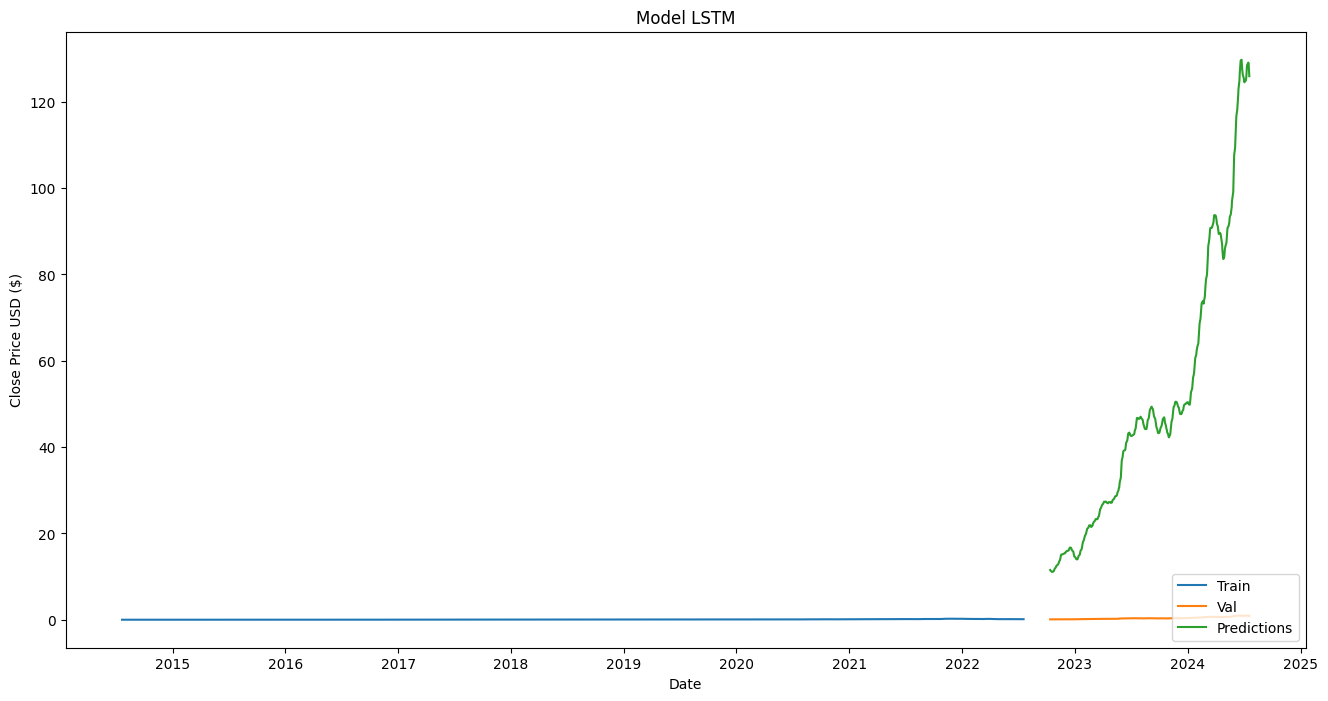

In [58]:
# Menampilkan hasil prediksi
train = data_close[:training_data_len]
valid = data_close[training_data_len:]
valid = valid.iloc[time_step:]  # Menyesuaikan panjang data validasi
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Date'], train['Close/Last'])
plt.plot(valid['Date'], valid[['Close/Last', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()